# SVM Kernels for mid price indicator prediction

The goal of this notebook is to present results obtained by trying different kernels and parameters for mid price prediction from [1].

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '2051', '4481', '3107', '1243', '11234'][:5]

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, data_dir='data/INDEX/', cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 4496
Testing set length for 10795: 1498
Cross-validation set length for 10795: 1498
Training set length for 12098: 3592
Testing set length for 12098: 1197
Cross-validation set length for 12098: 1197
Training set length for 11618: 3792
Testing set length for 11618: 1264
Cross-validation set length for 11618: 1264
Training set length for 2051: 3635
Testing set length for 2051: 1211
Cross-validation set length for 2051: 1211
Training set length for 4481: 3903
Testing set length for 4481: 1301
Cross-validation set length for 4481: 1301


In [3]:
dfs[stocks[0]].head()

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-13 10:57:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1489.0, 1874.0), (1490.0, 4866.0), (1491.0, ...",1488.0,1489.0,1488.5,1874.0,800.0,1.0,-0.401645
2013-09-13 10:59:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 220.0), (1491.0, 3642.0), (1492.0, 5...",1488.0,1490.0,1489.0,220.0,3967.0,1.0,0.894913
2013-09-13 11:00:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1491.0, 905.0), (1492.0, 5591.0), (1493.0, 6...",1489.0,1491.0,1490.0,905.0,2807.0,1.0,0.512392
2013-09-13 11:01:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1492.0, 4077.0), (1493.0, 6616.0), (1494.0, ...",1490.0,1492.0,1491.0,4077.0,1563.0,0.0,-0.445745
2013-09-13 11:03:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 1738.0), (1491.0, 4491.0), (1492.0, ...",1488.0,1490.0,1489.0,1738.0,4642.0,1.0,0.455172


In [4]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Results

For each stock we will present roc curves for SVMs with calculated roc areas compared to previous logistic regression results.

In [5]:
reg_log = {}
pred_log = {}
pred_out_of_sample = {}
for s in stocks:
    reg_log[s] = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log[s] = reg_log[s].predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))

#### 10795

* linear with $C=0.005$
* rbf with defaults

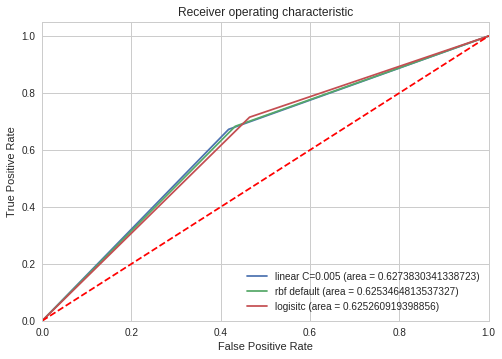

In [6]:
s = '10795'
reg_svm = svm_classification(dfs[s], 'linear', C=0.005)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('linear C=0.005', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'rbf')
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf default', logit_roc_auc))

logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log[s])
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log[s])
plt.plot(fpr, tpr, label='{} (area = {})'.format('logisitc', logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

#### 12098 

* linear with $C=0.005$
* rbf with  $C=10$, $gamma=0.1$

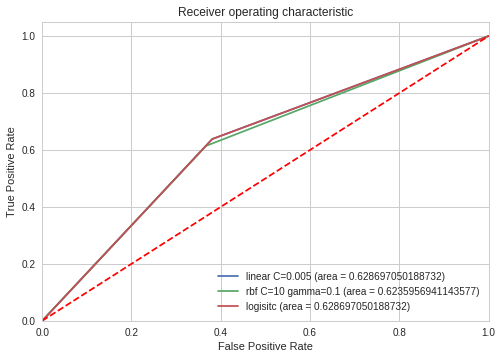

In [7]:
s = '12098'
reg_svm = svm_classification(dfs[s], 'linear', C=0.005)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('linear C=0.005', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'rbf', C=10, gamma=0.1)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf C=10 gamma=0.1', logit_roc_auc))

logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log[s])
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log[s])
plt.plot(fpr, tpr, label='{} (area = {})'.format('logisitc', logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

#### 11618 

* linear default
* rbf with $C=1000$, $gamma=1$
* rbf default
* sigmoid with $C=0.1$, $gamma=0.1$ and $coef0=0.5$

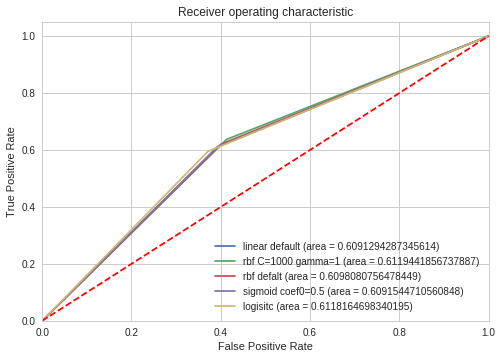

In [8]:
s = '11618'

reg_svm = svm_classification(dfs[s], 'linear')
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('linear default', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'rbf', C=1000, gamma=1)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf C=1000 gamma=1', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'rbf')
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf defalt', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'sigmoid', C=0.1, gamma=0.1, coef0=0.5)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('sigmoid coef0=0.5', logit_roc_auc))

logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log[s])
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log[s])
plt.plot(fpr, tpr, label='{} (area = {})'.format('logisitc', logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

#### 2051 

* linear default
* rbf default
* sigmoid with $coef0=0.5$, $gamma=1000$, $C=0.01$

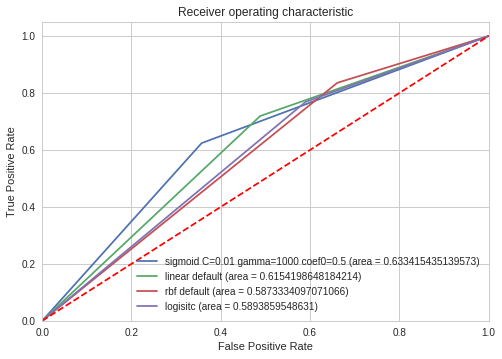

In [9]:
s = '2051'
reg_svm = svm_classification(dfs[s], 'sigmoid', C=0.01, gamma=1000, coef0=0.5)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('sigmoid C=0.01 gamma=1000 coef0=0.5', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'linear')
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('linear default', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'rbf')
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf default', logit_roc_auc))


logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log[s])
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log[s])
plt.plot(fpr, tpr, label='{} (area = {})'.format('logisitc', logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

#### 4481

* rbf with $C=1.5$, $gamma=0.1$
* rbf default
* sigmoid with $C=0.1$, $gamma=0.1$, $coef0=0.05$

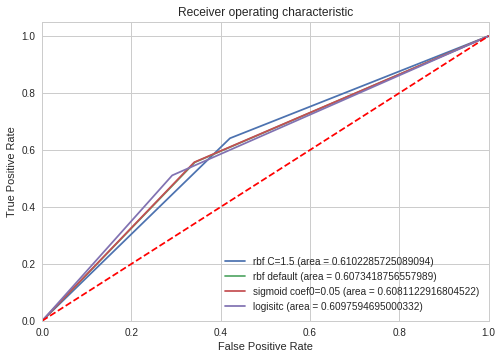

In [12]:
s = '4481'
reg_svm = svm_classification(dfs[s], 'rbf', C=1.5, gamma=0.1)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf C=1.5', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'rbf')
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('rbf default', logit_roc_auc))

reg_svm = svm_classification(dfs[s], 'sigmoid', C=0.1, gamma=0.1, coef0=0.05)
pred_svm_out_of_sample = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_svm_out_of_sample)
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_svm_out_of_sample)
plt.plot(fpr, tpr, label='{} (area = {})'.format('sigmoid coef0=0.05', logit_roc_auc))

logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log[s])
fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log[s])
plt.plot(fpr, tpr, label='{} (area = {})'.format('logisitc', logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Conclusions

There are no common parameters for SVM - for each stock even the choice of the kernel varies.

* linear and rbf kernels are always worth a try
* for rbf kernel it takes time to tune parameters, for linear kernel they can be found easily
* sigmoid kernel in some cases brings very good results, but usually it's much much worse than the other kernels
* the biggest improvement is for stock 2051 - we used sigmoid kernel. We improved by 5%
* usually improvement is rather small - max 1%

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>